In [20]:
# Библиотеки для обработки данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import datasets,models,layers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [18]:
# Библиотеки для построения архитектуры ResNet18
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

In [4]:
# Adding TF Cifar10 Data ..
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

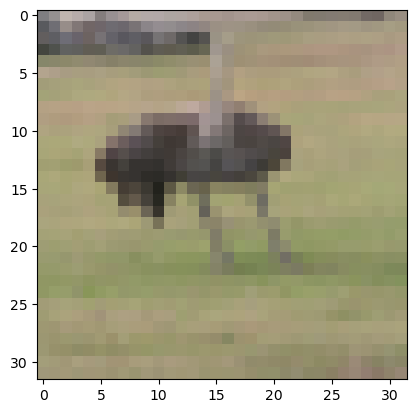

In [6]:
# Drawing sample . 
plt.imshow(X_train[42]);

In [7]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [11]:
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [17]:
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [19]:
class ResnetBlock(Model):
    """
    Стандартный блок архитектуры ResNet
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: количество каналов = количество ядер свёртки
        """
        super().__init__() # Перенимаем инициализируемые параметры у материнского класса Model

        self.__channels = channels # Задаём количество каналов (ядер свёртки)
        self.__down_sample = down_sample # Задаём параметр, отвечающий за сжатие
        self.__strides = [2, 1] if down_sample else [1, 1] # Задаём шаги ядер при свёртке
        # (в случае down_sample = True, шаг увеличивается в 2 раза и, следовательно, производится сжатие в 2 раза)

        KERNEL_SIZE = (3, 3) # Размер ядра
        INIT_SCHEME = "he_normal" # Закон генерации весов в ядре (здесь нормальный закон)

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME) # Первый слой 2D свёртки
        self.bn_1 = BatchNormalization() # Нормализация значений, полученных на предыдущем слое
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME) # Второй слой 2D свёртки
        self.bn_2 = BatchNormalization()
        self.merge = Add() # Слой поэлементного сложения (пока ничего не складывает, сложение будет дальше)

        if self.__down_sample:
            # Производим сжатие данных в случае down_sample = True
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs # Сохраняем исходные данные
        
        """
        Производим обработку входных данных по слоям блока:
        """
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out # Выводим результат обработки блоком ResNet входных данных


class ResNet18(Model):
    """
    Непосредственно архитектура ResNet18:
    """

    def __init__(self, num_classes, **kwargs):
        """
        num_classes: количество классов в решаемой задаче
        """
        super().__init__(**kwargs)
        
        
        """
        Собираем архитектуру из готовых блоков, созданных нами ранее:
        """
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")
        
    def call(self, inputs):
        """
        Производим обработку входных данных по слоям блока:
        """
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [25]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
# Используем категориальную кроссэнтропию для классов, представленных через one-hot encoding
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_20 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet_block_8 (ResnetBloc  multiple                  74368     
 k)                                                              
                                                                 
 resnet_block_9 (ResnetBloc  multiple                  74368     
 k)                                                    

In [26]:
es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
STEPS = len(X_train) / 256
history = model.fit(
    aug.flow(X_train,Y_train,batch_size = 256),
    steps_per_epoch=STEPS,
    batch_size = 256,
    epochs=50,
    validation_data=(X_train, Y_train),
    callbacks=[es]
)

Epoch 1/50
156/156 [==============================] - 150s 924ms/step - loss: 1.6349 - accuracy: 0.4295 - val_loss: 1.9174 - val_accuracy: 0.3593
Epoch 2/50
156/156 [==============================] - 143s 916ms/step - loss: 1.2541 - accuracy: 0.5487 - val_loss: 1.6889 - val_accuracy: 0.4225
Epoch 3/50
156/156 [==============================] - 143s 916ms/step - loss: 1.1040 - accuracy: 0.6062 - val_loss: 1.3715 - val_accuracy: 0.5168
Epoch 4/50
156/156 [==============================] - 144s 919ms/step - loss: 0.9838 - accuracy: 0.6487 - val_loss: 1.1912 - val_accuracy: 0.5893
Epoch 5/50
156/156 [==============================] - 144s 920ms/step - loss: 0.9023 - accuracy: 0.6793 - val_loss: 1.2944 - val_accuracy: 0.5703
Epoch 6/50
156/156 [==============================] - 146s 935ms/step - loss: 0.8245 - accuracy: 0.7073 - val_loss: 0.8510 - val_accuracy: 0.6949
Epoch 7/50
156/156 [==============================] - 147s 942ms/step - loss: 0.7740 - accuracy: 0.7258 - val_loss: 0.9504 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


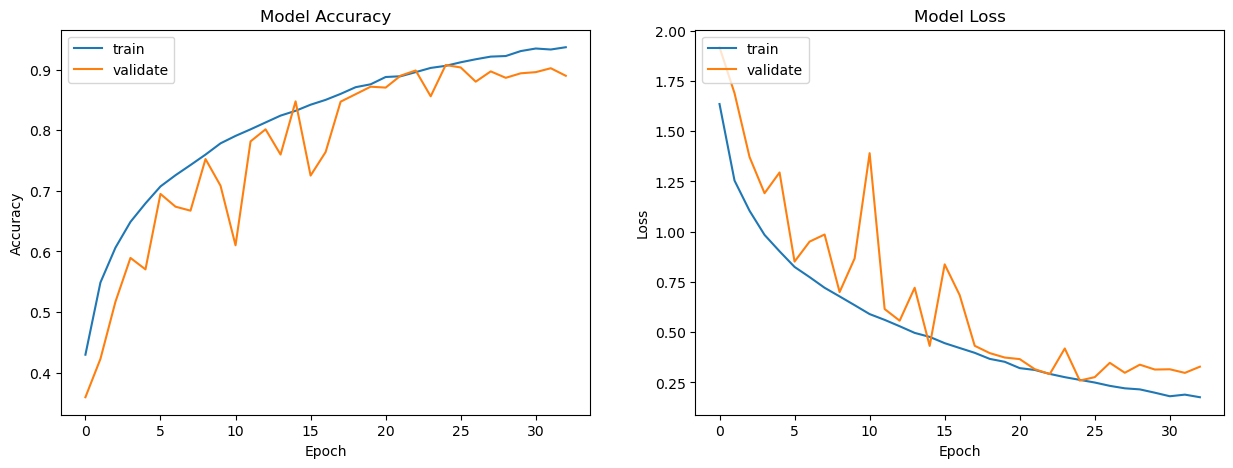

In [27]:
def plotmodelhistory(history): 
    
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    
    plt.show()

print(history.history.keys())
plotmodelhistory(history)

## Evaluation

In [28]:
ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 23s 18ms/step - loss: 0.2592 - accuracy: 0.9078
Model Loss is 0.2592269480228424
Model Accuracy is 0.9077500104904175
